# Large Language Model for PII detection

This notebook serves to present the fine-tuning and evaluation of a DeBerta model for NER, trained through Huggingface.

**Purpose and Scope:** This notebook mainly serves as a detailed explanation, evaluation and discussion of the DeBERTa model, it's learning curves and it's results. While comparing it to the aforementioned Heuristic Mixture Model, that served as an attempt at a light-weight, transparent and explainable model for PII detection. As previously mentioned, the HMM did not obtain scores as one could've hoped, which is why a heavier model LMM model is necessary. What this notebook will not go into detail of, is the actual code of the fine-tuning of the model - as the training of LLMs, like the DeBERTa requires huge amounts of compute (40gbs of RAM in this case) - which is why we've opted to train the model through the HPC in a separate script. 

**Goal:** The primary goal of this notebook, will therefore be to compare the achieved results to those of the HMM. 

**Approach:** The approach will involve a short theory-section, for the intriuged reader, before diving into the overall evaluation of the model, and a comparison to that of the HMM. 

**Notes:** The overall structure of the pre-processing and training has been borrowed from: [Eisuke Mizutani](https://www.kaggle.com/code/emiz6413/train-deberta-v3-single-model-lb-0-966). 

An overview of the notebook is as follows:

**NoteBook Overview:**
1. [Theory](#1-theory)
    * [Transformers and their role within NER](#11-transformers-and-their-role-within-ner)
    * [The self-attention mechanism](#12-the-self-attention-mechanism)
    * [DeBERTa - Decoding-enhanced BERT with disentangled attention](#13-deberta---decoding-enhanced-bert-with-disentangled-attention)
2. [Fine-tuning DeBERTa](#2-fine-tuning-deberta)
    * [Fine-tuning parameters](#21-fine-tuning-parameters)
    * [Train, Validation and Test](#22-train-validation-and-test-the-data)
    * [Notable additions](#23-notable-additions)
3. [Model training](#3-model-training)
    * [Learning Curves](#31---learning-curves)
    * [Feature Engineering](#preceeding-words-analysis-on-xtrain)
    * [Creating Dataframes](#creating-dfs)
4. [Model Evaluation](#4-model-evaluation)
    * [Loading and tokenizing data](#41-loading-and-tokenizing-data)
    * [Loading model and instantiating Huggingface Trainer](#42-loading-model-and-instantiating-huggingface-trainer)
    * [Predicting on data](#43-predicting-on-data)
    * [Evaluation of predictions](#44-evaluation-of-predictions)
5. [Conclusion](#6-conclusion)


# 1. Theory
## 1.1 Transformers and their role within NER
The Transformer architecture, has been recognized for revolutionizing Natural Language Processing (NLP), since it's [introduction](https://arxiv.org/abs/1706.03762) in 2017 - particularly in Language Translation, Text Generation and Named Entity Recognition. Characterized by their self-attention mechanism, transformers can process sequences of data in parallel, making them highly efficient and effective at capturing complex language patterns. 

In the context of Named Entity Recognition (NER), transformers have become particularly valuable. Transformers, pre-trained on large datasets and then fine-tuned for NER tasks, such as BERT, excel in this by capturing the nuances and context of language, leading to more accurate and robust entity recognition. This has quickly made them indispensable tools in extracting structured information, usable for tasks such as NER.

## 1.2 The self-attention mechanism

As mentioned, the self-attention mechanism is highly valuable in NER, as it enables the model to understand words by their context within a sentence. It does so, by learning token representations, based on the tokens them-selves, as well as the tokens deemed most important in the context of the specific token. The self-attention mechanism utilizes three learnt weight matrices - the **$W_{K}$**, **$W_{Q}$** and **$W_{V}$** matrices - in order to calculate the self-attention for all tokens simultaneously. 

Firstly, the Transformer-input, $X$, is projected onto the weight-matrices, in order to produce what is known as the **Queries (Q)**, **Keys (K)** and **Values (V)**.

$\text{\textbf{Q}} = \textbf{XW}_{Q}, \qquad \text{\textbf{K}} = \textbf{XW}_{K}, \qquad \text{\textbf{V}} = \textbf{XW}_{V}$

The Queries and Keys are then used to calculate the Attention scores for each token within a sentence:

$$\text{Attention} = \text{Softmax} \left ( \frac{\textbf{Q} \cdot \textbf{K}^T}{\sqrt{d_k}} \right ),$$

Here, the Attention scores represent how each token should attend to all other tokens, i.e. providing a weighted importance that informs the model which tokens are important for each specific token. The Softmax function is applied to ensure that these attention weights sum to 1, normalizing the scores so that they can be effectively compared and utilized across different contexts. Meanwhile, the **Values** are understood as a learned embedding per token.

Finally, the token-representations, $\textbf{Z}$, are calculated by creating a linear combination of all the **Values**, based on the attention between tokens like so:
$$\textbf{Z} = \text{Attention} \cdot \textbf{V}$$
I.e. if *tokens 3, 7 and 10* are deemed to atteend highly to *token 3*, the final token-representation will be a linear combination of the **Values** of *tokens 3, 7 and 10* - based on their individual attention weights.

Self-attention allows the model to weigh and consider all parts of the input sentence when understanding each word. Each token in a sentence is given attention scores relative to all other tokens, enabling the model to capture a more contextual representation of each word.

For NER, this ability is crucial. By understanding the context in which a word appears, transformers can accurately classify tokens as named entities (like names, organizations, or locations) or other parts of speech. The model processes the entire sentence and uses the relationships between words to determine if a token is part of a named entity, by classifying on the token-representations, $\textbf{Z}$. This contextual awareness, powered by self-attention, means that transformers can recognize entities even when they appear in complex or ambiguous sentences.

## 1.3 DeBERTa - Decoding-enhanced BERT with disentangled attention

DeBERTa, an acronym for Decoding-enhanced BERT with disentangled attention, represents a significant evolution in the field of Natural Language Processing (NLP). This model builds on the groundbreaking achievements of its predecessor, the Bidirectional Encoder Representations from Transformers, or BERT.

**BERT - a brief introduction**

BERT revolutionized NLP by leveraging transformer architectures, primarily through the use of "self-attention" to process sequences of data. Unlike previous models, BERT processes words in relation to all other words in a sentence, rather than in sequential order. The novel idea here, was to make the model predict masked tokens within sentences, rather than predicting sentence-continuations. This allows BERT to capture a richer context and understand the nuances of language more effectively, as it is able to understand words, within the context of both preceeding and succeding words. By pre-training on a large corpus of text and then fine-tuning on specific tasks, BERT achieved state-of-the-art results on a wide range of NLP benchmarks.

**Innovations of DeBERTa**

Developed by Microsoft, DeBERTa enhances the transformer-based model introduced by BERT through two innovative techniques. Firstly, it refines BERT's attention mechanism by introducing a disentangled attention mechanism. This novel approach separates the influence of content from positional context. In traditional models like BERT, attention mechanisms do not distinctly differentiate the content of a word from its position in a sentence. DeBERTa addresses this by considering both what words mean and where they appear, enabling a more nuanced understanding of text. This dual attention mechanism allows DeBERTa to excel in interpreting subtle meanings and complex linguistic relationships, thereby improving its performance on a variety of NLP tasks.

Furthermore, DeBERTa incorporates an enhanced mask decoder that improves the model’s ability to predict and reconstruct masked words - that are intentionally hidden during training to challenge the model’s understanding. This enhancement is particularly valuable in tasks that require precise word recognition and contextual awareness, such as filling in blanks and predicting the next words in sentences.

Through these advancements, DeBERTa not only builds upon but also significantly exceeds the capabilities of BERT, redefining the benchmarks for model performance in the NLP domain.

# 2. Fine-tuning DeBERTa

Thankfully, HuggingFace has made fine-tuning of state-of-the-art models, easier than ever before. As mentioned, this notebook won't go into detail about the training, of the model, but rather summarize it in 5 very short steps, as the main focus of this notebook will be the evaluation of said model. The curious reader is encouraged to take a look at the attached `/deberta_v3/train.py`-script. 

## 2.1 Fine-tuning parameters
The pretrained model and tokenizer, was in our case the: `microsoft/deberta-v3-large` model from HuggingFace.

The final model was fine-tuned with the following parameters, 

**Epochs and Learning Rate:**
- The model was fine-tuned for just 3 epochs.
- A learning rate of 2.5e-5 was used.

**Batch Size:**
- A training batch size of 1 and an evaluation batch size of 8 were used. 
- Batch size affects the gradient estimation and training stability, which is why we opted for such a small training batch size. 

**Learning Rate Scheduler:**
- A linear learning rate scheduler was applied, which gradually reduces the learning rate from the initial set value to zero, following a linear decay, in order to not overshoot minimas the further into training we get. 

**Warmup Ratio and Weight Decay:**
- The warmup ratio was set to 0.1, meaning 10% of the total training steps are used to gradually ramp up the learning rate from zero.
- A weight decay of 0.01 was applied as regularization to reduce overfitting.

**Model Initialization:**
- The first 6 layers of the classification layer were freezed, in order to potentially speed up training and focus learning on the upper layers of the network.

## 2.2 Train, Validation and Test
The Kaggle competition provided us with a training-set of 6807 essays, as well as an unlabeled test-set to use for the competition submission. Meanwhile, a [Kaggle-user](https://www.kaggle.com/datasets/mpware/pii-mixtral8x7b-generated-essays) provided an additional 2692 essays generated with Mixtral8x7B-Instruct model from Mistral AI. 

We opted to do a 70/30 split on the original data, while also including the extra data as training data. 
That way we ended up with 7457 training examples and 2042 testing/validation examples. 

## 2.3 Notable additions

In the detection of PII, Recall is incredibly important, as we cannot risk to miss any labeling of personal information. 
Therefore, we opted to imnclude a *confidence threshold* of 0.90 for the 'O' class. Thus, if the model wasn't at least 90% confident in it's 'O' prediction, the model would resort to the next most probable class.

Meanwhile, predictions of the model were created in two steps:
1) A prediction through regular DeBERTa-classification. 
2) A Regex-check for URLs, Phone-numbers and Emails on all tokens classified with 'O' during post-processing.

# 3. Model training

## 3.1 - Learning Curves

Below, a function is created to plot the .csv files created from the model-training. 

We'll be plotting the:
1) Train- and evaluation loss curves
2) The overall f5, recall and precision on the evaluation data
3) The f5-scores per individual label throughout training (on evaluation)

In [43]:
import pandas as pd
import os
import plotly.graph_objects as go

def plot_learning_curves(folder_name, title, y_limit=None, focus_file=None):
    # Define the path to the folder containing CSV files
    folder_path = f'../logs/deberta_v2_E3_Mf5_LRlinear2.5e-05_WR0.1_WD0.01/tensorboard/{folder_name}'
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    # Check if the folder contains CSV files
    if not csv_files:
        print("No CSV files found in the directory.")
        return

    # Create a Plotly graph object figure
    fig = go.Figure()
    
    # Initialize variables to store the minimum value step
    min_value_step = None

    # Check if this is the focus file to find the minimum value step
    if focus_file:
        data = pd.read_csv(focus_file)
        min_value_index = data['Value'].idxmax()
        min_value_step = data.at[min_value_index, 'Step']

    # Process each file
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        data = pd.read_csv(file_path)
        

        # Plotting the data
        fig.add_trace(go.Scatter(
            x=data['Step'],
            y=data['Value'],
            mode='lines',
            name=file[:-4].capitalize()  # Remove '.csv' from label and capitalize
        ))

    # Update the layout to add titles and labels
    fig.update_layout(
        title=title,
        xaxis_title="Step",
        yaxis_title="Value",
        legend_title="Metrics",
        font=dict(
            family="Courier New, monospace",
            size=14,
            color="black"
        )
    )
    
    # Setting the y-axis limits if provided
    if y_limit is not None:
        fig.update_yaxes(range=y_limit)
    
    # If we have a minimum value step, plot a vertical line
    if min_value_step is not None:
        fig.add_vline(x=min_value_step, line=dict(color="red", width=2, dash='dash'),
                      annotation_text="Lowest Value", annotation_position="top right")

    # Show the plot
    fig.show()


In [51]:
plot_learning_curves(folder_name = 'loss', title = 'Loss curves', y_limit=(0, 0.018))

#### Take-aways
The loss curves show that the DeBERTa model is really quick at fine-tuning to the PII labels. The train-curve quickly reduces before plateauing at around step 400. The training and evaluation curves follow each other really nicely, with no signs of overfitting on the training data. 

In [50]:
plot_learning_curves(folder_name = 'metrics_overall', title = 'Overall evaluation f5, recall and precision', y_limit=(0.6, 1.02))

#### Take-aways
It's seen that the model immediately obtains f5 scores at around 0.92, and is able to increase the performance to 0.96 by the end of training.

The f5-score and recall are almost identical throughout training, however, this is not a coincidence. As the $f_{\beta}$-metric is a metric where larger $\beta$-values heavily favor recall over precision, as given by the formula.

$$
F_\beta=\frac{1+\beta^2}{\frac{\beta^2}{\text { Recall }}+\frac{1}{\text { Precision }}}
$$

Putting our attention toward the Precision, we see a huge increase throughout training, starting at 0.65 and ending around 0.85-0.9.

In [49]:
plot_learning_curves(folder_name = 'f5_per_label', title = 'f5 per label', y_limit=(0, 1.1))

#### Take-aways
Comparing the learning curves of the individual labels, it's immediately noticeable that *phone numbers* and *emails* constantly score values at $≈1.0$. 

Thankfully, phone-numbers and emails are quite easy to catch through simple regex-rules, which is most likely why they score as highly as they do. 
Meanwhile, URL is not quite as stable, but does end up at 0.99 in the last step. - It's important to note here, that the labels distinguish between personal URLs and regular URLs (like Wikipedia etc.), which is most-likely why Regex isn't able to catch all of the URLs.

Usernames seeem to be the most difficult class in the beginning, however, through training the f5 greatly improves. 

Meanwhile, Street-addresses are the second-most difficult labels to classify at the start, but training barely improves performance in this case. Street-addresses usually consist of many consecutive tokens, which could be why these are more difficult to catch. 

Comparing to that of the HMM, it's strange to see phone-number scoring such a high f5!
This is most likely explained by the second Regex pass of the LLM, whereas the HMM uses regex as a feature for the model. This means, that even though the phone-numbers were registered by the Regex feature, it's unsure whether the model puts high importance on the specific feature - especially taking into consideration the incredibly low amount of phone-numbers present in both train and test data.

# 4. Model Evaluation

This section will predict on the entirety of the Validation set, and assess performance in both F5, accuracy as well as in a Confusion Matrix, as seen in the HMM evaluation. 

Firstly, we'll load all the necessary packages for making the model work. 

In [6]:
import os, re, sys
import numpy as np
import pandas as pd
import argparse
from pathlib import Path
from transformers import DebertaV2TokenizerFast, DebertaV2ForTokenClassification, DataCollatorForTokenClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch
import json
from types import SimpleNamespace

from datasets import Dataset, DatasetDict
from spacy.lang.en import English
nlp = English()

from utils import CustomPredTokenizer, get_predictions
from sklearn.metrics import fbeta_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

def load_data(DATA_DIR, args):

    data = {}

    # Train data
    with Path(f"{DATA_DIR}/train.json").open("r") as f:
        original_data = json.load(f)

    with Path(f"{DATA_DIR}/mpware_mixtral8x7b_v1.1-no-i-username.json").open("r") as f:
        extra_data = json.load(f)

    data['train'] = DatasetDict()

    original_data = pd.DataFrame(original_data)
    original_train, original_val = train_test_split(original_data, test_size=0.3, random_state=args.seed, shuffle=True)

    for _key, _data in zip(["original", "extra"], [original_train, pd.DataFrame(extra_data)]):
        data['train'][_key] = Dataset.from_dict({
            "full_text": _data["full_text"],
            "document": _data['document'].apply(lambda x: str(x)), 
            "tokens": _data["tokens"],
            "trailing_whitespace": _data["trailing_whitespace"],
            "provided_labels": _data["labels"]
        })

    with open(str(Path(DATA_DIR).joinpath("test.json")), "r") as f:
        _test = json.load(f)

    # Testdata
    data['test'] = Dataset.from_dict({
        "full_text": [x["full_text"] for x in _test],
        "document": [x["document"] for x in _test],
        "tokens": [x["tokens"] for x in _test],
        "trailing_whitespace": [x["trailing_whitespace"] for x in _test],
    })

    # Testdata
    data['val'] = Dataset.from_dict({
        "full_text": original_val["full_text"],
        "document": original_val['document'].apply(lambda x: str(x)), 
        "tokens": original_val["tokens"],
        "trailing_whitespace": original_val["trailing_whitespace"],
        "provided_labels": original_val["labels"]
    })

    data['all_labels'] = [
    'B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-ID_NUM', 'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'I-URL_PERSONAL', 'O'
    ]

    data['id2label'] = {i: l for i, l in enumerate(data['all_labels'])}
    data['label2id'] = {v: k for k, v in data['id2label'].items()}
    data['target'] = [l for l in data['all_labels'] if l != "O"]

    return data

/opt/anaconda3/envs/adv_ba/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



### Inserting model arguments

In [7]:
data = {'inference_max_length': 3072,
        'conf_thresh': 0.9,
        'url_thresh': 0.1,
        'model_path': '../deberta_v3/model',
        'metric': 'f5',
        'data_dir': '../data',
        'seed': 42,
        'full_determinism': False,
        'AMP': False,}

args = SimpleNamespace(**data)
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.AMP = True if str(args.device) == 'cuda' else False

## 4.1 Loading and tokenizing data

The data is loaded, and passed through the tokenizer, in order to create the validation set

In [8]:
data = load_data(args.data_dir, args)

# Instantiate tokenizer
tokenizer = DebertaV2TokenizerFast.from_pretrained(args.model_path)

# Tokenize dataset 
data['val'] = data['val'].map(CustomPredTokenizer(tokenizer=tokenizer, max_length=args.inference_max_length), 
                num_proc=os.cpu_count())

Map (num_proc=12): 100%|██████████| 2043/2043 [00:20<00:00, 99.27 examples/s] 


## 4.2 Loading model and instantiating Huggingface Trainer

In [9]:
model = DebertaV2ForTokenClassification.from_pretrained(args.model_path)
collator = DataCollatorForTokenClassification(tokenizer)
train_args = TrainingArguments(".", 
                                per_device_eval_batch_size=1, 
                                report_to="none", 
                                fp16=args.AMP, 
                                use_cpu=(str(args.device) == 'cpu'))

trainer = Trainer(
    model=model, 
    args=train_args, 
    data_collator=collator, 
    tokenizer=tokenizer,
)

## 4.3 Predicting on data

Prediction on the entire validation set takes hours to complete without heavy GPUs. We've therefore predicted once, and opted to just load the predictions within this notebook. 

In [24]:
import ast
LOAD_PREDICTIONS = True

if not LOAD_PREDICTIONS:
    print("Predicting on validation....")
    data_val = data['val']
    _, data_val = get_predictions(data_val, trainer, model, args, nlp, return_all = True)

else:
    data_val = pd.read_pickle(f'../data/val_predictions.pkl')

## 4.4 Evaluation of predictions

As in the HMM, we'll start by computing the F5 score, with the inclusion of the 'O'-label. As mentioned, the vast majority of the data consists of 'O', which is why this score is not especially useful. 

In [25]:
print("Calculating f5 score....")
non_O_ids = [item != 'O' for sublist in data_val['pred_labels'] for item in sublist]
true_labels = np.array([data['label2id'][item] for sublist in data_val['provided_labels'] for item in sublist])
pred_labels = np.array([data['label2id'][item] for sublist in data_val['pred_labels'] for item in sublist])

# On all classes
print(f"F5 score (ALL): {fbeta_score(true_labels, pred_labels, average='micro', beta=5)}")

Calculating f5 score....
F5 score (ALL): 0.9997839660248352


Now, the accuracy and f5 will be calculated on all non-O labels.

In [31]:
# f5 score
print(f"F5 score (Excluding O): {fbeta_score(true_labels[non_O_ids], pred_labels[non_O_ids], average='micro', beta=5)}")
# Calculate accuracy
print(f"Accuracy (Excluding O): {np.mean(true_labels[non_O_ids] == pred_labels[non_O_ids])}")

F5 score (Excluding O): 0.7294642857142857
Accuracy (Excluding O): 0.7294642857142857


We see an increase of roughly 30 percentage points compared to out HMM!

Creating confusion matrix

In [29]:
pred_labels_named = [data['id2label'][ele] for ele in pred_labels]
true_labels_named = [data['id2label'][ele] for ele in true_labels]

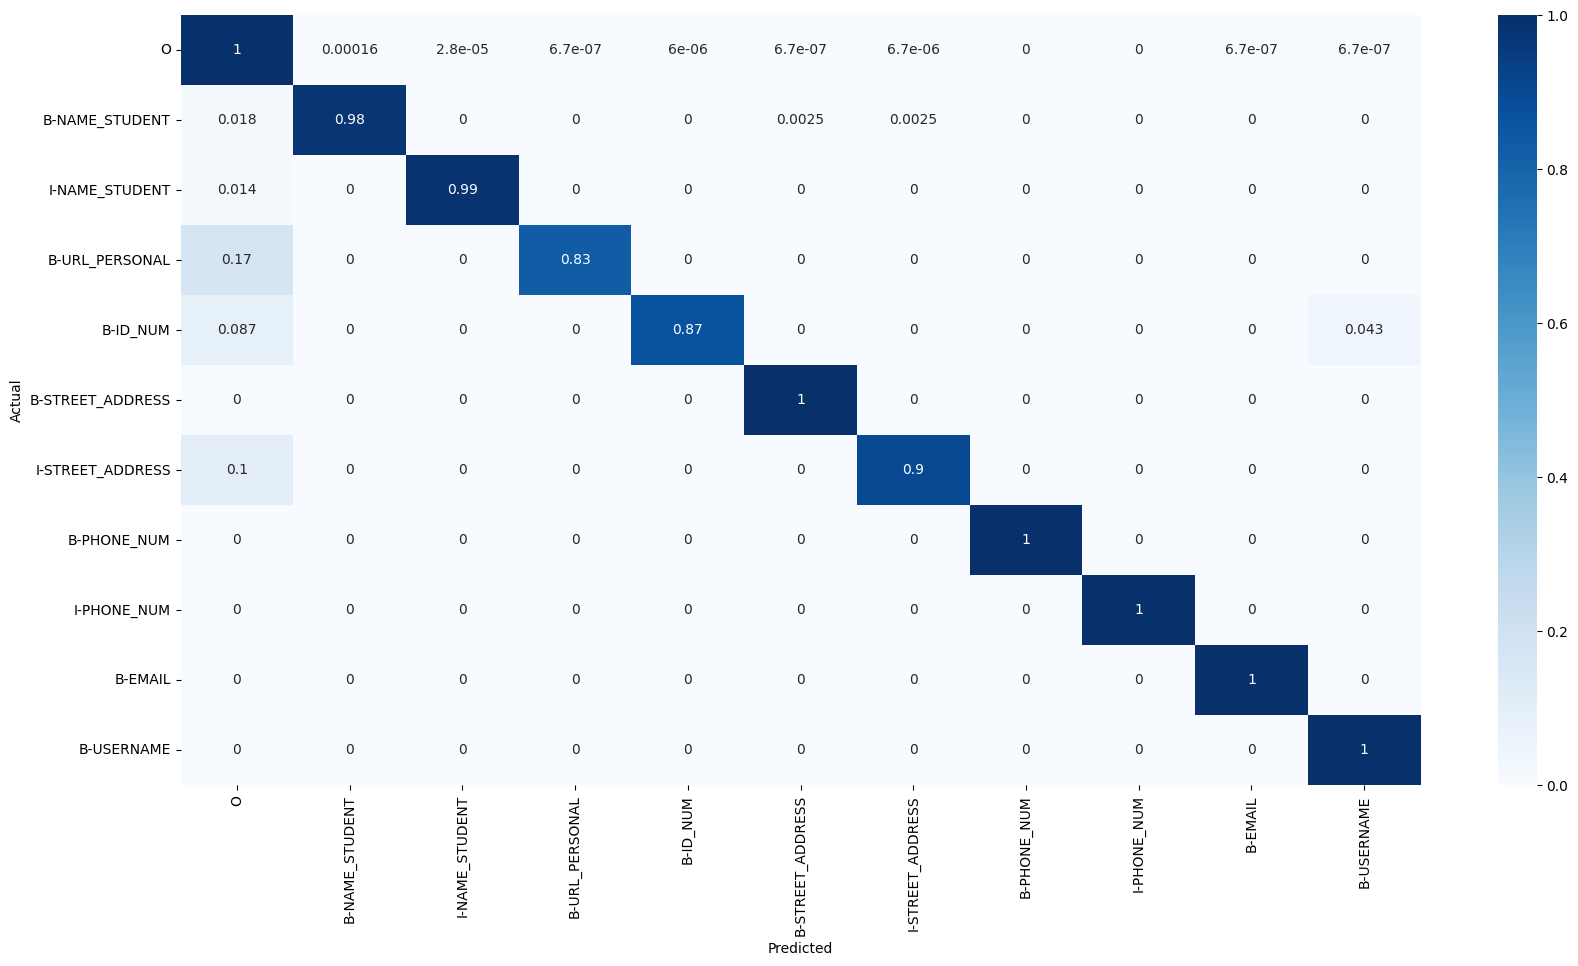

In [30]:
labels = ['O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-URL_PERSONAL', 'B-ID_NUM', 'B-STREET_ADDRESS', 'I-STREET_ADDRESS', 'B-PHONE_NUM', 'I-PHONE_NUM', 'B-EMAIL', 'B-USERNAME']
# we create heatmap of our predictions and labels
conf_matrix = confusion_matrix(true_labels_named, pred_labels_named, labels=labels, normalize='true')
# normalize the confusion matrix
plt.figure(figsize=(20, 10))
sns.heatmap(conf_matrix, annot=True, vmin=0, cmap='Blues', vmax=1,
            xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

As indicated by the very clear line throughout the diagonal of the confusion matrix, then we've clearly created a very good model here :)


Looking at the individual Predicted-columns, it's seen that we very rarely mislabel a PII-label, as being another different PII-label - instead, when misclassifying, labels are almost always misclassified as 'O'. 

Comparing the Predicted 'O'-column, with the Actual 'O'-row - it's seen that there's a larger tendency of predicting 'O', when in fact it was PII, rather than predicting PII when in fact it was 'O'. This is a shame, as it indicates that the model does let some PII-information through our system - whereas, we'd much rather mistakenly label 'O'-tokens as being PII. 

But all in all, this is a very good looking confusion matrix. 

# 5. Conclusion

In this notebook, we explored the use of the DeBERTa model for Named Entity Recognition - while comparing it to the previously evaluated HMM. 

The final evaluation metrics found were:

- Accuracy (Without 'O' labels): 0.72946
- F5 score (With 'O' labels): 0.99978

Thus making the model much better than the evaluated HMM, which is a shame as it is nowhere near as transparent and explainable - though we could've spent more time on the explainability of the model, possibly exploring the attention-module within the model. Though the model is already surprisingly good, there's no doubt that the following considerations could further improve the model: 

- **Hyperparameter tuning:** We could attempt to further tune the hyperparameters of the model to improve its performance. Particularly the amount of frozen layers could end up having a huge on the model performance. 
- **More training data:** LLMs usually require vast amounts of data, which is why the provided number of essays is nowhere near what could've been utilized by the LLM. As mentioned, part of the training data was generated through other LLMs, which is a great resource at gathering more training data. 

**Key Takeaways:**
- DeBERTa is a great resource for fine-tuning NER tasks, it's clearly got a great contextual awareness of tokens already, while barely any epochs are needed to fine-tune it to the specific task of NER. However, the LLM comes at a large cost of compute, for both training and inference, making it expensive and resource-extensive.